In [ ]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air/notebooks')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 25108
-rw------- 1 root root 5517847 Jun 12 09:36 '01 Result Data Cleaning Part 1.csv'
-rw------- 1 root root 1964974 Jun 12 09:36 '02 Data Preperation.ipynb'
-rw------- 1 root root  256098 Jun 12 09:36 '02 X_test.csv'
-rw------- 1 root root 4831129 Jun 12 09:36 '02 X_train.csv'
-rw------- 1 root root   40580 Jun 12 09:36 '02 y_test.csv'
-rw------- 1 root root  770651 Jun 12 09:36 '02 y_train.csv'
-rw------- 1 root root 1032328 Jun 13 12:22 '03 ARIMA.ipynb'
-rw------- 1 root root   34981 Jun 13 10:58  03_arima_results.csv
-rw------- 1 root root 6247212 Jun 12 09:36  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  631448 Jun 12 09:36  06_DataPreperation_ML.ipynb
-rw------- 1 root root 1611961 Jun 12 09:36  07a_best_model.keras
-rw------- 1 root root  371715 Jun 12 09:36  07a_LSTM_Manggarai.ipynb
-rw------- 1 root root 1685693 Jun 12 09:36  07b_best_model.keras
-rw------- 1 root root  368771 Jun 12 09:36  07b_LSTM_

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import boxcox, boxcox_normmax, boxcox_llf, chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.stats.diagnostic import acorr_ljungbox, lilliefors
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
import gc
import os
import time
warnings.filterwarnings('ignore')

# Functions Needed

In [ ]:
def plot_acf_pacf(data, period, lag):
    fig, axes = plt.subplots(1, 2, figsize=(14, 12))

    # ACF Plot
    for lag in range(period, lag+1, period):
        axes[0].axvline(x=lag, color='red', linestyle='--', linewidth=1, zorder=0)
    plot_acf(data, ax=axes[0], lags=lag, marker='o', markersize=3)
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF Plot
    for lag in range(period, lag+1, period):
        axes[1].axvline(x=lag, color='red', linestyle='--', linewidth=1, zorder=0)
    plot_pacf(data, ax=axes[1], lags=lag, marker='o', markersize=3)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

def boxcox_transformation(data):
    lambda_opt = boxcox_normmax(data, method='mle').item()

    # Log-likelihood with optimum lambda
    llf_opt = boxcox_llf(lambda_opt, data)

    # Log-likelihood if lambda = 1
    llf_null = boxcox_llf(1.0, data)

    # Calculate LRT
    lrt_stat = (2 * (llf_opt - llf_null)).item()

    # Calculate p-value (df = 1)
    p_value = chi2.sf(lrt_stat, df=1)

    print(f"Lambda optimal: {lambda_opt:.4f}")
    print(f"LRT statistic: {lrt_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    return lambda_opt

def inverse_transform(transformed_data, lambda_opt):
    if lambda_opt == 0:
        return np.exp(transformed_data)  # Log case: e^(transformed_data)
    elif lambda_opt == 1:
        return transformed_data  # No transformation case
    else:
        return np.power(transformed_data, 1/lambda_opt)

def modelling(order, data_y_train_trans, data_y_train, data_y_test, seasonal_order=None, exog=False, data_x_train=None, data_x_test=None, lambda_opt=1.0):

    # Generate model name automatically
    if seasonal_order is None:
        model_name = f"ARIMA{order}"
        if exog:
            model_name = f"ARIMAX{order}"
    else:
        model_name = f"SARIMA{order}x{seasonal_order}"
        if exog:
            model_name = f"SARIMAX{order}x{seasonal_order}"

    print(f"\n{'='*60}")
    print(f"Testing {model_name}")
    print(f"{'='*60}")

    # Start timing
    start_time = time.time()

    try:
        # Create model based on parameters
        if seasonal_order is None:
            # ARIMA or ARIMAX
            if exog and data_x_train is not None:
                model = SARIMAX(data_y_train_trans, exog=data_x_train, order=order)
            else:
                model = ARIMA(data_y_train_trans, order=order)
        else:
            # SARIMA or SARIMAX
            if exog and data_x_train is not None:
                model = SARIMAX(data_y_train_trans, exog=data_x_train,
                              order=order, seasonal_order=seasonal_order)
            else:
                model = SARIMAX(data_y_train_trans, order=order, seasonal_order=seasonal_order)

        # Fit the model
        print("Fitting model...")
        if seasonal_order is None and not exog:
            results = model.fit()
        else:
            results = model.fit(disp=False)

        print("Model fitted successfully!")
        print(results.summary())

        # Calculate training time
        training_time = time.time() - start_time

        # Get residuals for diagnostic tests
        residuals = results.resid

        # Ljung-Box Test (test for white noise)
        ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
        ljung_box_pvalue = ljung_box_result['lb_pvalue'].iloc[0]
        print(f"\nLjung-Box Test:\n{ljung_box_result}")

        # Lilliefors Test (test for normality)
        stat, lillie_pvalue = lilliefors(residuals)
        print(f"Lilliefors Test: statistic={stat:.4f}, p-value={lillie_pvalue:.4f}")

        # Check if all variables are significant
        pvalues = results.pvalues
        all_significant = all(pvalues < 0.05)

        print("Calculating training metrics...")

        fitted_values = results.fittedvalues  # These are in transformed space
        fitted_values_transformed = inverse_transform(fitted_values, lambda_opt)

        # Calculate all training metrics
        rmse_train = np.sqrt(mean_squared_error(data_y_train, fitted_values_transformed))
        mae_train = mean_absolute_error(data_y_train, fitted_values_transformed)
        r2_train = r2_score(data_y_train, fitted_values_transformed)
        mape_train = mean_absolute_percentage_error(data_y_train, fitted_values_transformed)

        print(f"Training RMSE: {rmse_train:.4f}")
        print(f"Training MAE: {mae_train:.4f}")
        print(f"Training R²: {r2_train:.4f}")
        print(f"Training MAPE: {mape_train:.2f}%")

        print("Calculating testing metrics...")

        # Your original calculation (which was correct!)
        if exog and data_x_test is not None:
            forecast = results.forecast(steps=len(data_y_test), exog=data_x_test)
        else:
            forecast = results.forecast(steps=len(data_y_test))

        forecast_transformed = inverse_transform(forecast, lambda_opt)

        # Calculate all testing metrics
        rmse_test = np.sqrt(mean_squared_error(data_y_test, forecast_transformed))
        mae_test = mean_absolute_error(data_y_test, forecast_transformed)
        r2_test = r2_score(data_y_test, forecast_transformed)
        mape_test = mean_absolute_percentage_error(data_y_test, forecast_transformed) * 100

        print(f"Testing RMSE: {rmse_test:.4f}")
        print(f"Testing MAE: {mae_test:.4f}")
        print(f"Testing R²: {r2_test:.4f}")
        print(f"Testing MAPE: {mape_test:.2f}%")

        # Print diagnostic test results
        print(f"\nDiagnostic Tests:")
        print(f"Ljung-Box p-value: {ljung_box_pvalue:.6f} ({'White Noise' if ljung_box_pvalue > 0.05 else 'Not White Noise'})")
        print(f"Lilliefors p-value: {lillie_pvalue:.6f} ({'Normal Distribution' if lillie_pvalue > 0.05 else 'Not Normal'})")
        print(f"All variables significant: {'Yes' if all_significant else 'No'}")

        # Create results dictionary with all metrics (matching XGBoost/LSTM format)
        results_dict = {
            'Model': model_name,
            'Semua Variabel Signifikan': 'Ya' if all_significant else 'Tidak',
            'P-value Ljung Box': f"{ljung_box_pvalue:.6f}",
            'White Noise?': 'Ya' if ljung_box_pvalue > 0.05 else 'Tidak',
            'P-value Lillie Test': f"{lillie_pvalue:.6f}",
            'Distribusi Normal?': 'Ya' if lillie_pvalue > 0.05 else 'Tidak',
            'Training Time (s)': f"{training_time:.2f}",
            'RMSE Training': f"{rmse_train:.4f}",
            'RMSE Testing': f"{rmse_test:.4f}",
            'MAE Training': f"{mae_train:.4f}",
            'MAE Testing': f"{mae_test:.4f}",
            'MAPE Training': f"{mape_train:.2f}",
            'MAPE Testing': f"{mape_test:.2f}",
            'R² Training': f"{r2_train:.4f}",
            'R² Testing': f"{r2_test:.4f}",
        }

        print(f"\nModel {model_name} completed successfully!")

        # Memory cleanup
        del model, results, fitted_values, fitted_values_transformed, forecast, forecast_transformed, residuals

    except Exception as e:
        print(f"Error fitting {model_name}: {str(e)}")
        training_time = time.time() - start_time

        # Create error results dictionary
        results_dict = {
            'Model': model_name,
            'Semua Variabel Signifikan': 'Error',
            'P-value Ljung Box': 'Error',
            'White Noise?': 'Error',
            'P-value Lillie Test': 'Error',
            'Distribusi Normal?': 'Error',
            'Training Time (s)': f"{training_time:.2f}",
            'RMSE Training': 'Error',
            'RMSE Testing': 'Error',
            'MAE Training': 'Error',
            'MAE Testing': 'Error',
            'MAPE Training': 'Error',
            'MAPE Testing': 'Error',
            'R² Training': 'Error',
            'R² Testing': 'Error'
        }

    csv_file = '03_arima_results.csv'

    try:
        # Read existing results if file exists
        if os.path.exists(csv_file):
            existing_df = pd.read_csv(csv_file)
            # Add new result
            new_df = pd.concat([existing_df, pd.DataFrame([results_dict])], ignore_index=True)
        else:
            # Create new dataframe
            new_df = pd.DataFrame([results_dict])

        # Save back to CSV
        new_df.to_csv(csv_file, index=False)
        print(f"Results saved to {csv_file}")

    except Exception as save_error:
        print(f"Error saving to CSV: {save_error}")

# Import Data

In [ ]:
y_train = pd.read_csv('02 y_train.csv', index_col='Tanggal')
y_test = pd.read_csv('02 y_test.csv', index_col='Tanggal')

print(y_train.head())
print(y_test.head())

                     manggarai_air
Tanggal                           
2021-10-17 00:00:00          590.0
2021-10-17 01:00:00          575.0
2021-10-17 02:00:00          570.0
2021-10-17 03:00:00          565.0
2021-10-17 04:00:00          560.0
                     manggarai_air
Tanggal                           
2025-03-05 00:00:00          795.0
2025-03-05 01:00:00          795.0
2025-03-05 02:00:00          765.0
2025-03-05 03:00:00          765.0
2025-03-05 04:00:00          740.0


# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [ ]:
lambda_opt = round(boxcox_transformation(y_train),1)

Lambda optimal: 1.3854
LRT statistic: 390.5658
P-value: 0.000000


In [ ]:
print(f"{lambda_opt}")

1.4


Karena P-Value LR test lambda(1) = 0.000000 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [ ]:
y_train_pow = y_train ** lambda_opt
boxcox_transformation(y_train_pow)

Lambda optimal: 0.9896
LRT statistic: 0.4320
P-value: 0.511013


0.989550194258247

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [ ]:
result = adfuller(y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -8.893371724037205
p-value       : 1.2253541962665829e-14
Critical Values:
   1% : -3.430570978789697
   5% : -2.861637666602819
   10% : -2.5668219849607934


Karena p-value 1.225e-14 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

# ACF PACF

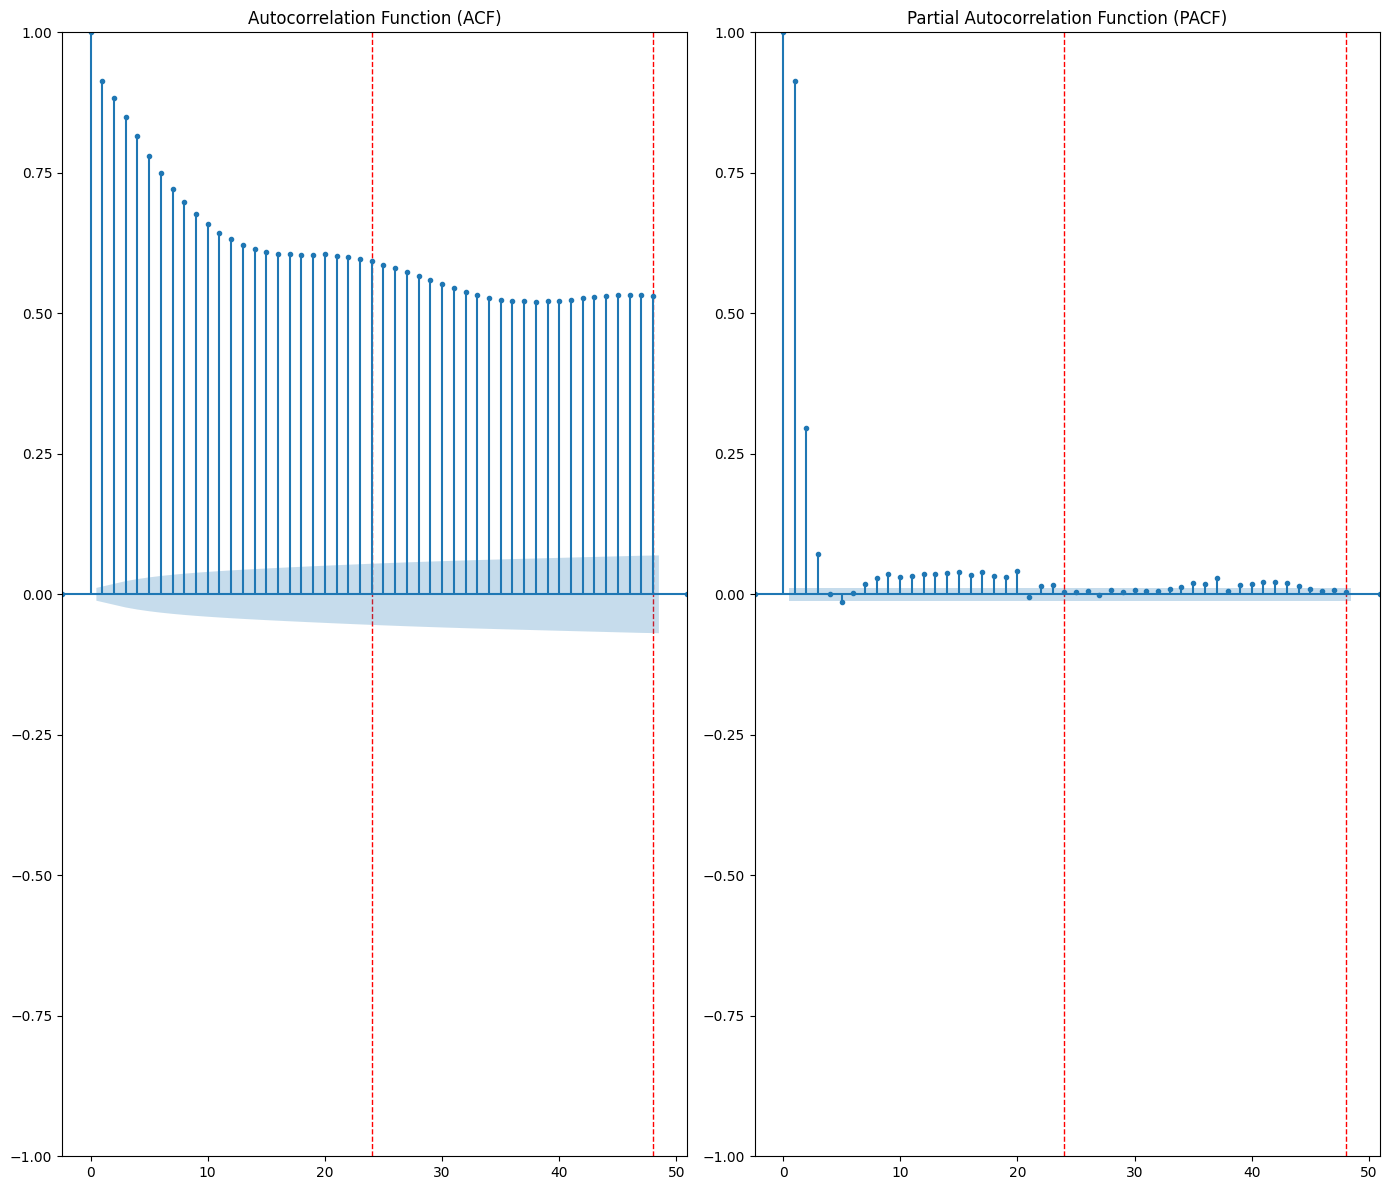

In [ ]:
plot_acf_pacf(y_train_pow, 24, 48)

# Modelling

In [ ]:
# AR Model based on PACF
for p in range(1,22):
    order = (p,0,0)
    modelling(
        order=order,
        exog=False,
        data_y_train_trans=y_train_pow,
        data_y_train=y_train,
        data_y_test=y_test,
        lambda_opt=lambda_opt
    )


Testing ARIMA(1, 0, 0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -214512.264
Date:                Thu, 12 Jun 2025   AIC                         429030.528
Time:                        14:41:20   BIC                         429055.418
Sample:                    10-17-2021   HQIC                        429038.519
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5778     33.209    247.992      0.000    8170.489    8300.666
ar.L1          0.9141      0.001   1052.727      0.000       0.

In [ ]:
# MA model
for q in range(1,41):
    order = (0,0,q)
    modelling(
        order=order,
        exog=False,
        data_y_train_trans=y_train_pow,
        data_y_train=y_train,
        data_y_test=y_test,
        lambda_opt=lambda_opt
    )


Testing ARIMA(0, 0, 1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -229948.285
Date:                Thu, 12 Jun 2025   AIC                         459902.570
Time:                        14:48:53   BIC                         459927.461
Sample:                    10-17-2021   HQIC                        459910.561
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5854      5.617   1466.114      0.000    8224.576    8246.595
ma.L1          0.6954      0.001    622.846      0.000       0.

KeyboardInterrupt: 

In [ ]:
# MA model
for q in range(32,41):
    order = (0,0,q)
    modelling(
        order=order,
        exog=False,
        data_y_train_trans=y_train_pow,
        data_y_train=y_train,
        data_y_test=y_test,
        lambda_opt=lambda_opt
    )

In [ ]:
# ARMA and SARMA model
for p in range (1, 5):
    for q in range(1,16):
        for season in [None, (1,0,0,24), (0,0,1,24), (1,0,1,24)]:
            order = (p,0,q)
            modelling(
                order=order,
                exog=False,
                data_y_train_trans=y_train_pow,
                data_y_train=y_train,
                data_y_test=y_test,
                seasonal_order=season,
                lambda_opt=lambda_opt
            )

Streaming output truncated to the last 5000 lines.
ma.L3         -0.0058      0.004     -1.509      0.131      -0.013       0.002
ma.L4         -0.0395      0.007     -5.995      0.000      -0.052      -0.027
ar.S.L24       0.9975      0.001   1165.412      0.000       0.996       0.999
ma.S.L24      -0.9930      0.002   -619.829      0.000      -0.996      -0.990
sigma2      1.042e+05     96.419   1081.044      0.000    1.04e+05    1.04e+05
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):          79708193.54
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -6.47
Prob(H) (two-sided):                  0.11   Kurtosis:                       256.72

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

Ljung-Box Test:
       lb_stat     lb_pvalue
10  362.420893  9.193142e-72
Lilliefors Test: statistic=0.2999, p-value=0.0

In [ ]:
order = (2,0,10)
modelling(
    order=order,
    exog=False,
    data_y_train_trans=y_train_pow,
    data_y_train=y_train,
    data_y_test=y_test,
    seasonal_order=(1,0,1,24),
    lambda_opt=lambda_opt
)


Testing SARIMA(2, 0, 10)x(1, 0, 1, 24)
Fitting model...
Model fitted successfully!
                                       SARIMAX Results                                       
Dep. Variable:                         manggarai_air   No. Observations:                29640
Model:             SARIMAX(2, 0, 10)x(1, 0, [1], 24)   Log Likelihood             -212742.220
Date:                               Fri, 13 Jun 2025   AIC                         425514.441
Time:                                       02:15:45   BIC                         425638.894
Sample:                                   10-17-2021   HQIC                        425554.396
                                        - 03-04-2025                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

In [ ]:
# ARMA and SARMA model
for p in range (3, 5):
    for q in range(1,11):
        for season in [None, (1,0,0,24), (0,0,1,24), (1,0,1,24)]:
            order = (p,0,q)
            modelling(
                order=order,
                exog=False,
                data_y_train_trans=y_train_pow,
                data_y_train=y_train,
                data_y_test=y_test,
                seasonal_order=season,
                lambda_opt=lambda_opt
            )


Testing ARIMA(3, 0, 1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(3, 0, 1)   Log Likelihood             -213058.094
Date:                Fri, 13 Jun 2025   AIC                         426128.188
Time:                        06:48:49   BIC                         426177.969
Sample:                    10-17-2021   HQIC                        426144.170
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5779     44.816    183.765      0.000    8147.741    8323.415
ar.L1          0.6404      0.059     10.904      0.000       0.

In [ ]:
order = (4, 0, 5)
modelling(
    order=order,
    exog=False,
    data_y_train_trans=y_train_pow,
    data_y_train=y_train,
    data_y_test=y_test,
    seasonal_order=(1,0,1,24),
    lambda_opt=lambda_opt
)


Testing SARIMA(4, 0, 5)x(1, 0, 1, 24)
Fitting model...
Model fitted successfully!
                                      SARIMAX Results                                       
Dep. Variable:                        manggarai_air   No. Observations:                29640
Model:             SARIMAX(4, 0, 5)x(1, 0, [1], 24)   Log Likelihood             -213068.769
Date:                              Fri, 13 Jun 2025   AIC                         426161.538
Time:                                      12:34:28   BIC                         426261.101
Sample:                                  10-17-2021   HQIC                        426193.502
                                       - 03-04-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          

In [ ]:
# ARMA and SARMA model
for q in range(6,11):
    for season in [None, (1,0,0,24), (0,0,1,24), (1,0,1,24)]:
        order = (4,0,q)
        modelling(
            order=order,
            exog=False,
            data_y_train_trans=y_train_pow,
            data_y_train=y_train,
            data_y_test=y_test,
            seasonal_order=season,
            lambda_opt=lambda_opt
        )


Testing ARIMA(4, 0, 6)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(4, 0, 6)   Log Likelihood             -213056.696
Date:                Fri, 13 Jun 2025   AIC                         426137.393
Time:                        12:38:09   BIC                         426236.955
Sample:                    10-17-2021   HQIC                        426169.357
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5778     43.988    187.224      0.000    8149.363    8321.792
ar.L1          0.0132      4.768      0.003      0.998      -9.

In [ ]:
# ARMA and SARMA model
for q in range(1,6):
    for season in [None, (1,0,0,24), (0,0,1,24), (1,0,1,24)]:
        order = (5,0,q)
        modelling(
            order=order,
            exog=False,
            data_y_train_trans=y_train_pow,
            data_y_train=y_train,
            data_y_test=y_test,
            seasonal_order=season,
            lambda_opt=lambda_opt
        )


Testing ARIMA(5, 0, 1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(5, 0, 1)   Log Likelihood             -213055.592
Date:                Fri, 13 Jun 2025   AIC                         426127.183
Time:                        14:39:05   BIC                         426193.558
Sample:                    10-17-2021   HQIC                        426148.493
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5778     44.330    185.778      0.000    8148.692    8322.463
ar.L1          0.4453      0.555      0.802      0.422      -0.

In [ ]:
# ARMA and SARMA model
for q in range(6,11):
    for season in [None, (1,0,0,24), (0,0,1,24), (1,0,1,24)]:
        order = (5,0,q)
        modelling(
            order=order,
            exog=False,
            data_y_train_trans=y_train_pow,
            data_y_train=y_train,
            data_y_test=y_test,
            seasonal_order=season,
            lambda_opt=lambda_opt
        )


Testing ARIMA(5, 0, 6)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:          manggarai_air   No. Observations:                29640
Model:                 ARIMA(5, 0, 6)   Log Likelihood             -213055.164
Date:                Fri, 13 Jun 2025   AIC                         426136.327
Time:                        15:51:36   BIC                         426244.187
Sample:                    10-17-2021   HQIC                        426170.955
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8235.5778     43.896    187.614      0.000    8149.542    8321.613
ar.L1         -0.0039      2.257     -0.002      0.999      -4.

In [ ]:
# SAR and SMA
for p in range(1,5):
    for season in [(1,0,0,24), (0,0,1,24), (1,0,1,24)]:
        order = (p,0,0)
        modelling(
            order=order,
            exog=False,
            data_y_train_trans=y_train_pow,
            data_y_train=y_train,
            data_y_test=y_test,
            seasonal_order=season,
            lambda_opt=lambda_opt
        )

for q in range(1,16):
    for season in [(1,0,0,24), (0,0,1,24), (1,0,1,24)]:
        order = (0,0,q)
        modelling(
            order=order,
            exog=False,
            data_y_train_trans=y_train_pow,
            data_y_train=y_train,
            data_y_test=y_test,
            seasonal_order=season,
            lambda_opt=lambda_opt
        )


Testing SARIMA(1, 0, 0)x(1, 0, 0, 24)
Fitting model...
Model fitted successfully!
                                     SARIMAX Results                                      
Dep. Variable:                      manggarai_air   No. Observations:                29640
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -34593.449
Date:                            Fri, 13 Jun 2025   AIC                          69192.897
Time:                                    18:09:51   BIC                          69217.788
Sample:                                10-17-2021   HQIC                         69200.888
                                     - 03-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9982   1.12e-0

KeyboardInterrupt: 

In [ ]:
modelling(order, data_y_train_trans, data_y_train, data_y_test, seasonal_order=None, exog=False, data_x_train=None, data_x_test=None, lambda_opt=1.0):

In [ ]:
compare = pd.read_csv('03_Result_ARIMA.csv')
compare.tail(10)

,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,MAE Training,MAPE Training,RMSE Testing,MAE Testing,MAPE Testing,Training Time (seconds)
46,"ARIMA(0, 0, 26)",Ya,0.000453,Tidak,0.001,Tidak,7650.6897,7609.8884,92.62,40.9072,31.8161,5.97,508.83
47,"ARIMA(0, 0, 27)",Ya,0.000138,Tidak,0.001,Tidak,7650.6910,7609.8883,92.62,40.8735,31.7554,5.97,444.73
48,"ARIMA(0, 0, 28)",Ya,0.000056,Tidak,0.001,Tidak,7650.6911,7609.8886,92.62,40.8459,31.7162,5.96,560.12
49,"ARIMA(0, 0, 29)",Ya,0.000076,Tidak,0.001,Tidak,7650.6898,7609.8893,92.62,40.8310,31.7031,5.96,576.24
50,"ARIMA(0, 0, 30)",Ya,0.000381,Tidak,0.001,Tidak,7650.6872,7609.8905,92.62,40.8230,31.6929,5.96,712.57
51,"ARIMA(0, 0, 31)",Ya,0.002497,Tidak,0.001,Tidak,7650.6831,7609.8920,92.62,40.8200,31.7006,5.96,629.20
52,"ARIMA(0, 0, 32)",Ya,0.016039,Tidak,0.001,Tidak,7650.6784,7609.8937,92.62,40.8211,31.7097,5.96,725.86
53,"ARIMA(0, 0, 33)",Ya,0.081427,Ya,0.001,Tidak,7650.6732,7609.8955,92.62,40.8241,31.7161,5.96,719.38
54,"ARIMA(0, 0, 34)",Ya,0.226061,Ya,0.001,Tidak,7650.6688,7609.8970,92.62,40.8265,31.7195,5.96,973.26
55,"ARIMA(0, 0, 35)",Ya,0.448953,Ya,0.001,Tidak,7650.6650,7609.8983,92.62,40.8284,31.7250,5.96,904.26


In [ ]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-3)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,0)', 'model_type': 'ARIMA', 'order': (8,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(10,0,0)', 'model_type': 'ARIMA', 'order': (10,0,0), 'seasonal_order': None, 'exog': False},
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -211985.459
Date:                Wed, 28 May 2025   AIC                         423976.917
Time:                        10:47:01   BIC                         424001.810
Sample:                    10-16-2021   HQIC                        423984.909
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9310     30.184    250.392      0.000    7498.771    7617.091
ar.L1          0.9133      0.001   1052.321      0.000       0.91

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,21.4668,40.7089
1,Manggarai (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,19.8556,40.3410
2,Manggarai (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,19.7526,40.2858
3,Manggarai (air),"ARIMA(4,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7515,40.2836
4,Manggarai (air),"ARIMA(5,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7512,40.2918
5,Manggarai (air),"ARIMA(6,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7511,40.2889
6,Manggarai (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7487,40.2744
7,Manggarai (air),"ARIMA(8,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7414,40.2510
8,Manggarai (air),"ARIMA(9,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7293,40.2251
9,Manggarai (air),"ARIMA(10,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7197,40.2040


In [ ]:
# Try MA models
ma_configs = [
    {'name': 'ARIMA(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': False},
]
ma_comparison = modelling (ma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma_comparison


Testing ARIMA(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -227334.312
Date:                Wed, 28 May 2025   AIC                         454674.623
Time:                        10:49:22   BIC                         454699.516
Sample:                    10-16-2021   HQIC                        454682.614
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9375      5.111   1478.744      0.000    7547.920    7567.955
ma.L1          0.6939      0.001    624.292      0.000       0.69

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,31.9612,42.5656
1,Manggarai (air),"ARIMA(0,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,27.3017,42.4171
2,Manggarai (air),"ARIMA(0,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,24.9531,42.2806
3,Manggarai (air),"ARIMA(0,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,23.4915,42.1536
4,Manggarai (air),"ARIMA(0,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,22.5255,42.0283
5,Manggarai (air),"ARIMA(0,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,21.8819,41.9327
6,Manggarai (air),"ARIMA(0,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,21.4373,41.8236
7,Manggarai (air),"ARIMA(0,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,21.1194,41.7449
8,Manggarai (air),"ARIMA(0,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,20.8919,41.6753
9,Manggarai (air),"ARIMA(0,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,20.7075,41.6008


In [ ]:
# Try MA models
ma2_configs = [
    {'name': 'ARIMA(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,14)', 'model_type': 'ARIMA', 'order': (0,0,14), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,15)', 'model_type': 'ARIMA', 'order': (0,0,15), 'seasonal_order': None, 'exog': False}
]
ma2_comparison = modelling (ma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma2_comparison


Testing ARIMA(0,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 11)   Log Likelihood             -211786.405
Date:                Wed, 28 May 2025   AIC                         423598.810
Time:                        11:02:49   BIC                         423706.679
Sample:                    10-16-2021   HQIC                        423633.439
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9355     15.409    490.487      0.000    7527.734    7588.137
ma.L1          0.6832      0.001    802.100      0.000       0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,20.5692,41.5379
1,Manggarai (air),"ARIMA(0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,20.4521,41.4726
2,Manggarai (air),"ARIMA(0,0,13)",Ya,0.000000,Tidak,0.001000,Tidak,20.3583,41.4187
3,Manggarai (air),"ARIMA(0,0,14)",Ya,0.000000,Tidak,0.001000,Tidak,20.2810,41.3670
4,Manggarai (air),"ARIMA(0,0,15)",Ya,0.000000,Tidak,0.001000,Tidak,20.2094,41.3211


In [ ]:
# Try MA models
ma3_configs = [
    {'name': 'ARIMA(0,0,16)', 'model_type': 'ARIMA', 'order': (0,0,16), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,17)', 'model_type': 'ARIMA', 'order': (0,0,17), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,18)', 'model_type': 'ARIMA', 'order': (0,0,18), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,19)', 'model_type': 'ARIMA', 'order': (0,0,19), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,20)', 'model_type': 'ARIMA', 'order': (0,0,20), 'seasonal_order': None, 'exog': False},
]
ma3_comparison = modelling (ma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma3_comparison


Testing ARIMA(0,0,16)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 16)   Log Likelihood             -211142.733
Date:                Wed, 28 May 2025   AIC                         422321.466
Time:                        11:17:40   BIC                         422470.824
Sample:                    10-16-2021   HQIC                        422369.415
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9347     18.906    399.766      0.000    7520.880    7594.990
ma.L1          0.6527      0.001    772.664      0.000       0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,16)",Ya,0.000000,Tidak,0.001000,Tidak,20.1605,41.2887
1,Manggarai (air),"ARIMA(0,0,17)",Ya,0.000000,Tidak,0.001000,Tidak,20.1185,41.2577
2,Manggarai (air),"ARIMA(0,0,18)",Ya,0.000000,Tidak,0.001000,Tidak,20.0978,41.2278
3,Manggarai (air),"ARIMA(0,0,19)",Ya,0.000000,Tidak,0.001000,Tidak,20.0919,41.2053
4,Manggarai (air),"ARIMA(0,0,20)",Ya,0.000000,Tidak,0.001000,Tidak,20.0408,41.1464


In [ ]:
compare = pd.concat([ar_comparison,
                     ma_comparison,
                     ma2_comparison,
                     ma3_comparison
                     ])
compare.to_csv(f'model_comparison_{data_y_train.name}_results.csv')

In [ ]:
compare = pd.read_csv(f'model_comparison_{data_y_train.name}_results.csv', index_col=0)
compare

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(1,0,0)",Ya,0.0,Tidak,0.001,Tidak,21.4668,40.7089
1,Manggarai (air),"ARIMA(2,0,0)",Ya,0.0,Tidak,0.001,Tidak,19.8556,40.3410
2,Manggarai (air),"ARIMA(3,0,0)",Ya,0.0,Tidak,0.001,Tidak,19.7526,40.2858
3,Manggarai (air),"ARIMA(4,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7515,40.2836
4,Manggarai (air),"ARIMA(5,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7512,40.2918
5,Manggarai (air),"ARIMA(6,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7511,40.2889
6,Manggarai (air),"ARIMA(7,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7487,40.2744
7,Manggarai (air),"ARIMA(8,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7414,40.2510
8,Manggarai (air),"ARIMA(9,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7293,40.2251
9,Manggarai (air),"ARIMA(10,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7197,40.2040


In [ ]:
# SARIMA
sar_configs = [
    {'name': 'SARIMA(1,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(5,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
]
sar_comparison = modelling (sar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar_comparison


Testing SARIMA(1,0,0)x(1,0,0,24)
Fitting model...
Error fitting SARIMA(1,0,0)x(1,0,0,24): LU decomposition error.
Error cleanup: 0 objects collected

Testing SARIMA(2,0,0)x(1,0,0,24)
Fitting model...


: 